In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from pca_tools import pca_scores

In [2]:
pbp = pd.read_csv('play_by_play.csv')
pbp['teamID'] = pbp.offensive_team.astype(str) + pbp.season.astype(str)


In [3]:
pbp.columns

Index([u'date', u'game_ID', u'drive', u'qtr', u'down', u'time', u'yd_line',
       u'yds_to_endzone', u'yds_to_go', u'goal_to_go', u'first_down',
       u'offensive_team', u'defensive_team', u'description', u'play_attempted',
       u'yards_gained', u'scoring_play', u'touchdown', u'safety', u'play_type',
       u'passer', u'passer_ID', u'pass_attempt', u'pass_outcome',
       u'pass_length', u'air_yds', u'yac', u'qb_hit', u'pass_location',
       u'interception', u'rusher', u'rusher_ID', u'rush_attempt',
       u'run_location', u'run_gap', u'receiver', u'receiver_ID', u'reception',
       u'FG_result', u'sack', u'challenge', u'challenge_result',
       u'accepted_penalty', u'penalized_team', u'penalty_type',
       u'penalty_yards', u'season', u'teamID'],
      dtype='object')

In [4]:
# Filter Data 
# Only Passing plays without sacks
play_filter = (pbp.pass_outcome == 'Complete') #| (pbp.pass_outcome == 'Incomplete')
filtered_data = pbp[play_filter & (pbp.accepted_penalty == 0)]

In [5]:
teams = filtered_data.groupby('teamID').count()
teams.index

Index([u'ARI2009', u'ARI2010', u'ARI2011', u'ARI2012', u'ARI2013', u'ARI2014',
       u'ARI2015', u'ARI2016', u'ATL2009', u'ATL2010',
       ...
       u'TEN2016', u'WAS2009', u'WAS2010', u'WAS2011', u'WAS2012', u'WAS2013',
       u'WAS2014', u'WAS2015', u'WAS2016', u'nan2010'],
      dtype='object', name=u'teamID', length=257)

In [6]:
yd_bins = np.arange(-100, 101, 1)
distributions = np.zeros((teams.index.size - 1, len(yd_bins) - 1))
for i, team in enumerate(teams.index[:-1]):
        
    single_team = filtered_data[(filtered_data.teamID == team)]
    # Yards ball was in air
    #print(team)
    #print(team)
    #print(single_team.air_yds)
    all_plays = plt.hist(single_team.air_yds.values, bins=yd_bins)
    total_plays = single_team.play_attempted.count()
    
    # Normalized histogram for each team
    distributions[i, :] = all_plays[0] / total_plays
    plt.close()

In [7]:
single_team = filtered_data[(filtered_data.teamID == 'NO2016')]
plt.hist(single_team.air_yds.values, bins=yd_bins)

single_team = filtered_data[(filtered_data.teamID == 'CLE2016')]
plt.hist(single_team.air_yds.values, bins=yd_bins)
plt.show()



In [8]:
pca = PCA()
pca.fit(distributions)
mean_distribution = np.mean(distributions, axis=0)
n_components = len(yd_bins) - 1

In [9]:
plt.close()

In [10]:
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
x = np.arange(1, n_components + 1, 1)
plt.plot(x, cumulative_variance, 'ko-')

plt.xlabel('Principal component')
plt.ylabel('Cumulative proportion of variance explained')

plt.savefig('pca_variance.pdf')

In [11]:
n = 6

plt.figure(figsize=(6, 9))

plt.subplot(211)
plt.title('PCA Analysis of completed passes', fontsize=18)
plt.plot(yd_bins[:-1], mean_distribution, 'k--',linewidth=2, label='Mean Distribution')
plt.xlim([-20, 20])
plt.yticks(np.arange(0, .1, 0.01))
plt.legend(frameon=False, loc=2)
plt.subplot(212)
for i in range(n):
    if i == 4:
        plt.plot(yd_bins[:-1], pca.components_[i], label='Component: {}'.format(i + 1), linewidth=2)
plt.xlim([-20, 20])
plt.legend(frameon=False,loc=2)
plt.xlabel('Yards in the air', fontsize=12, labelpad=8)
plt.tight_layout()

plt.savefig('pca_components.pdf')

In [12]:
from pca_tools import pca_scores

In [13]:
scores = pca_scores(distributions, pca.components_[0:6, :])

In [14]:
scores

array([[-0.01746784,  0.0226213 , -0.04648101, ..., -0.00532765,
        -0.02310155, -0.06918777],
       [-0.0091231 , -0.00533827, -0.01396236, ...,  0.0275392 ,
         0.07158875,  0.02971481],
       [ 0.00224364,  0.01663212,  0.01748614, ..., -0.01745206,
         0.01099371,  0.00855259],
       [ 0.00675782, -0.02660826, -0.00405983, ...,  0.02193917,
        -0.01407023, -0.00615767],
       [-0.02750836, -0.00119836, -0.00841259, ...,  0.01214991,
         0.01587749, -0.0059028 ],
       [-0.0144588 ,  0.00924931,  0.00450567, ...,  0.00451924,
         0.00163689, -0.00243035]])

In [15]:
# Passing Totals
passing_totals = filtered_data.groupby('teamID').agg({'yards_gained' : 'sum'})
passing_totals = passing_totals.reset_index()

# Index to sort 
idx = passing_totals['yards_gained'].argsort().values

In [16]:
from scipy.stats import norm


In [17]:
%matplotlib inline

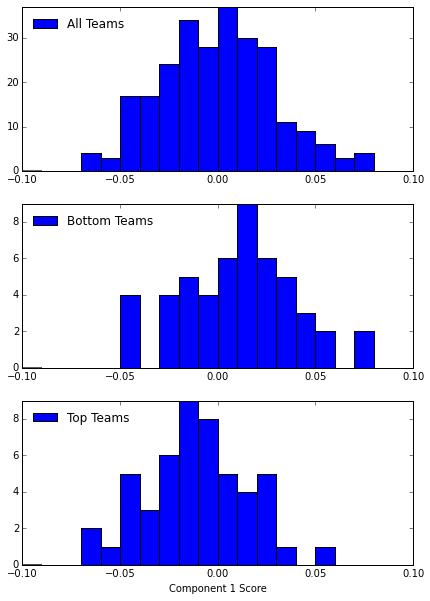

In [18]:
plt.figure(figsize=(7,10))
x = 0
top = 50
bins = np.arange(-.10, .11, .01)

plt.subplot(311)
plt.yticks(np.arange(0, 50, 10))

plt.hist(scores[x, :], bins=bins, color='b',label='All Teams')

plt.legend(frameon=False, loc=2)


sorted_scores = scores[x, :]
plt.subplot(312)
plt.yticks(np.arange(0, 10, 2))

lowest = plt.hist(sorted_scores[:top], alpha=1, bins=bins, color='b', label="Bottom Teams")
plt.legend(frameon=False, loc=2)

plt.subplot(313)
plt.yticks(np.arange(0, 10, 2))
highest = plt.hist(sorted_scores[256-top:], alpha=1, bins=bins, color='b', label='Top Teams')
plt.legend(frameon=False, loc=2)

plt.xlabel('Component 1 Score')

plt.savefig('component1.pdf')

In [19]:
low_mean = np.mean(sorted_scores[:top])
high_mean = np.mean(sorted_scores[256 - top:])
print(low_mean, high_mean)

(0.0097540493705600365, -0.010077182509204663)


In [20]:
from scipy.stats import ttest_ind

In [21]:
ttest_ind(sorted_scores[:top], sorted_scores[256-top:])

Ttest_indResult(statistic=3.5195475840246671, pvalue=0.00065744335662761509)

(-0.0066605470749721259, 0.001826000983337831)


Ttest_indResult(statistic=-1.6926422296190444, pvalue=0.093700553261369626)

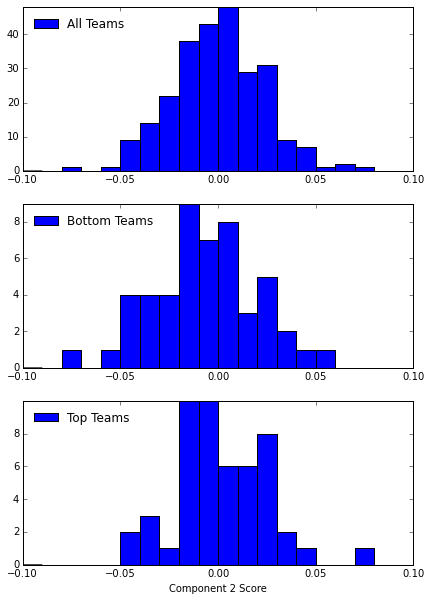

In [22]:
plt.figure(figsize=(7,10))
x = 1
top = 50
bins = np.arange(-.10, .11, .01)

plt.subplot(311)
plt.yticks(np.arange(0, 50, 10))

plt.hist(scores[x, :], bins=bins, color='b',label='All Teams')

plt.legend(frameon=False, loc=2)


sorted_scores = scores[x, :]
plt.subplot(312)
plt.yticks(np.arange(0, 10, 2))

lowest = plt.hist(sorted_scores[:top], alpha=1, bins=bins, color='b', label="Bottom Teams")
plt.legend(frameon=False, loc=2)

plt.subplot(313)
plt.yticks(np.arange(0, 10, 2))
highest = plt.hist(sorted_scores[256-top:], alpha=1, bins=bins, color='b', label='Top Teams')
plt.legend(frameon=False, loc=2)

plt.xlabel('Component 2 Score')

plt.savefig('component2.pdf')
low_mean = np.mean(sorted_scores[:top])
high_mean = np.mean(sorted_scores[256 - top:])
print(low_mean, high_mean)
ttest_ind(sorted_scores[:top], sorted_scores[256-top:])